<a href="https://colab.research.google.com/github/iamviji/project/blob/master/Report/KerasOneHot_10_10_argmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import time
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras import Model
from keras.layers.normalization import BatchNormalization


input_message_length = 10
encoder_output_length = 20
channel_size = 10
NUM_OF_INPUT_MESSAGE = 1000
SNR_STEP_SIZE = .5

SNR_BEGIN = 0
SNR_END = 10

bler_per_iter_uncoded_commpy_psk_2= [0.521, 0.473, 0.436, 0.37,  0.304, 0.259, 0.187, 0.138, 0.098, 0.098, 0.052, 0.028, 0.012, 0.011, 0.009, 0.002, 0.0,  0.001, 0.,    0.0]
bler_per_iter_uncoded_itpp_psk_2= [0.518, 0.478, 0.415, 0.355, 0.305, 0.227, 0.177, 0.149, 0.11,  0.075, 0.055, 0.023, 0.014, 0.014, 0.015, 0.001, 0.003, 0.001, 0.,    0. ]
bler_per_iter_uncoded_commpy_psk_4 = [0.815, 0.793, 0.75,  0.714, 0.64,  0.639, 0.526, 0.49,  0.433, 0.371, 0.335, 0.236, 0.204, 0.154, 0.129, 0.08,  0.063, 0.046, 0.023, 0.018]
bler_per_iter_uncoded_itpp_psk_4 = [0.814, 0.767, 0.729, 0.702, 0.66,  0.616, 0.563, 0.511, 0.442, 0.4,   0.294, 0.277, 0.228, 0.17,  0.114, 0.087, 0.05,  0.037, 0.022, 0.017]
bler_per_iter_ldpc_itpp_psk_4 = [0.584, 0.488, 0.404, 0.332, 0.218, 0.151, 0.097, 0.058, 0.041, 0.024, 0.007, 0.004, 0.002, 0.001, 0.001, 0.,    0.,    0.,    0.,    0.,   ]
bler_per_iter_ham_itpp_psk_4= [0.51, 0.479, 0.419, 0.333, 0.313, 0.247, 0.212, 0.132, 0.114, 0.093, 0.042, 0.027, 0.024, 0.016, 0.006, 0.005, 0.003, 0.002, 0.,    0.  ]


def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma


def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff


In [2]:

snr_std = 7.0

input_message_x = Input(shape=(2**input_message_length,))
# "encoded" is the encoded representation of the input
#enc_layer1 = Dense(encoder_output_length, activation='tanh')(input_message_x)
enc_layer2 = Dense(2*channel_size, activation='tanh')(input_message_x)
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(2*channel_size,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(2*channel_size,))
#dec_layer1 = Dense(encoder_output_length, activation='tanh')(encoded_input)
dec_layer2 = Dense(2**input_message_length, activation="softmax")(encoded_input)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))


print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           20500       input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.square (TFOpLambda)     (None, 20)           0           dense[0][0]                      
__________________________________________________________________________________________________
tf.math.reduce_mean (TFOpLambda ()                   0           tf.math.square[0][0]             
______________________________________________________________________________________________

In [3]:
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

test_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*2))
test_input_message_one_hot = numpy.zeros((test_input_message.size, 2**input_message_length))
test_input_message_one_hot[numpy.arange(test_input_message.size),test_input_message] = 1
print(test_input_message_one_hot)
print (test_input_message_one_hot.shape)
print (test_input_message.shape)

training_input_message_label = training_input_message.reshape(training_input_message.shape[1])
print (training_input_message)
print (training_input_message_label)
test_input_message_label = test_input_message.reshape(test_input_message.shape[1])
print (test_input_message)
print (test_input_message_label)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 1024)
(1, 10000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2000, 1024)
(1, 2000)
[[465 922 962 ... 608 142   8]]
[465 922 962 ... 608 142   8]
[[871 605 340 ... 351 718 371]]
[871 605 340 ... 351 718 371]


In [4]:
import keras
#Note : 3rd Round
#def custom_losff_fucntion (act, pred):
#  return (tf.reduce_mean(-1*(act * tf.log(pred) + (1-act)*tf.log(1-pred))))

#opt = keras.optimizers.Adam(learning_rate=1)
#autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
#loss_fn = keras.losses.SparseCategoricalCrossentropy()
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  #awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
  #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  #opt = keras.optimizers.Adam(learning_rate=0.003)
  #autoencoder.compile(optimizer=opt, loss=loss_fn)
  autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
  autoencoder.fit(training_input_message_one_hot, training_input_message_label,
                epochs=10,#original
                #epochs=20,
                batch_size=500,
                shuffle=False,
                validation_data=(test_input_message_one_hot, test_input_message_label))

Training for SNR= 0.0  sigma= 1.0
Epoch 1/10
20/20 [==============================] - 1s 38ms/step - loss: 6.3617 - sparse_categorical_accuracy: 0.2598 - val_loss: 5.0246 - val_sparse_categorical_accuracy: 0.7075
Epoch 2/10
20/20 [==============================] - 0s 18ms/step - loss: 4.5269 - sparse_categorical_accuracy: 0.7139 - val_loss: 3.6549 - val_sparse_categorical_accuracy: 0.7845
Epoch 3/10
20/20 [==============================] - 0s 19ms/step - loss: 3.2063 - sparse_categorical_accuracy: 0.7895 - val_loss: 2.5890 - val_sparse_categorical_accuracy: 0.8380
Epoch 4/10
20/20 [==============================] - 0s 19ms/step - loss: 2.2554 - sparse_categorical_accuracy: 0.8621 - val_loss: 1.7955 - val_sparse_categorical_accuracy: 0.8970
Epoch 5/10
20/20 [==============================] - 0s 19ms/step - loss: 1.5935 - sparse_categorical_accuracy: 0.9207 - val_loss: 1.2232 - val_sparse_categorical_accuracy: 0.9460
Epoch 6/10
20/20 [==============================] - 0s 18ms/step - loss

In [5]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(CHANEL_SIZE,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

#train_init = tf.global_variables_initializer ()
#train_sess = tf.Session ()

channel_in = []
channel_out = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
  #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  #opt = keras.optimizers.Adam(learning_rate=0.003)
  #autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    channel_in.append(encoded_message[0])
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    #noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,CHANEL_SIZE])
    noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,2*channel_size])
    channel_out.append(noised_message[0]) 
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    #decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output1", numpy.argmax(training_input_message_one_hot[i]))
    #print ("output2", numpy.argmax(decoded_message[0]))
    #print ("output2", training_input_message[0][i])
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0])):
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 19.28s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 38.77s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 58.59s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 78.86s
SNR: 0.000:
 -> BER: 0.28
 -> Total Time: 195.50s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 20.35s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 40.21s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 60.06s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 80.08s
SNR: 0.500:
 -> BER: 0.24
 -> Total Time: 200.69s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 20.10s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 40.03s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 59.97s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 79.82s
SNR: 1.000:
 -> BER: 0.17
 -> Total Time: 199.92s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 19.81s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 39.56s
SNR: 1.500 - Iter: 75

In [6]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor_argmax_2  = numpy.array(())
times_per_iter_dl_tensor_argmax_2 = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(CHANEL_SIZE,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

#train_init = tf.global_variables_initializer ()
#train_sess = tf.Session ()

channel_in = []
channel_out = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
  #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  #opt = keras.optimizers.Adam(learning_rate=0.003)
  #autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    channel_in.append(encoded_message[0])
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    #noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,CHANEL_SIZE])
    noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,2*channel_size])
    channel_out.append(noised_message[0]) 
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    #decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output1", numpy.argmax(training_input_message_one_hot[i]))
    #print ("output2", numpy.argmax(decoded_message[0]))
    #print ("output2", training_input_message[0][i])
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0])):
      argmax_idx = numpy.argmax(decoded_message[0])
      decoded_message[0][argmax_idx] = -100000
      if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0])):
        total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor_argmax_2=numpy.append(ber_per_iter_dl_tensor_argmax_2 ,ber)
  times_per_iter_dl_tensor_argmax_2=numpy.append(times_per_iter_dl_tensor_argmax_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 19.51s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 39.00s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 58.51s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 78.13s
SNR: 0.000:
 -> BER: 0.19
 -> Total Time: 195.15s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 19.96s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 39.34s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 58.77s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 78.04s
SNR: 0.500:
 -> BER: 0.14
 -> Total Time: 196.10s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 19.64s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 39.19s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 58.80s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 78.32s
SNR: 1.000:
 -> BER: 0.10
 -> Total Time: 195.95s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 19.60s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 39.16s
SNR: 1.500 - Iter: 75

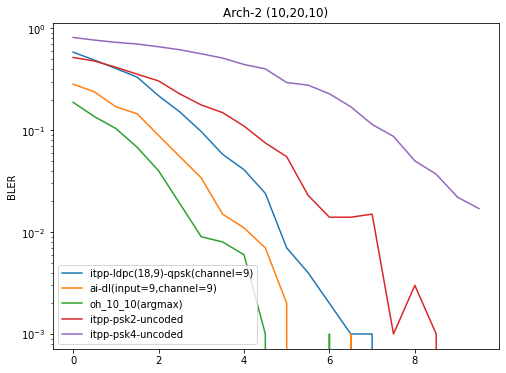

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(input=9,channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_argmax_2,'', label="oh_10_10(argmax)") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-psk4-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

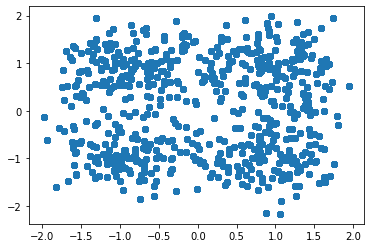

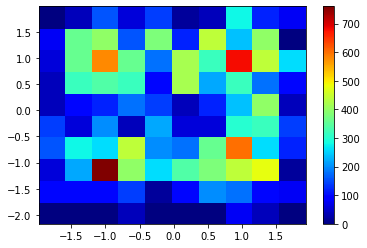

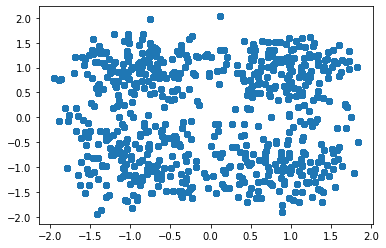

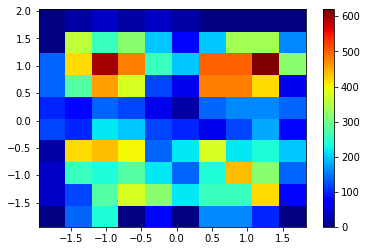

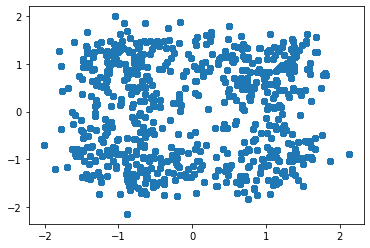

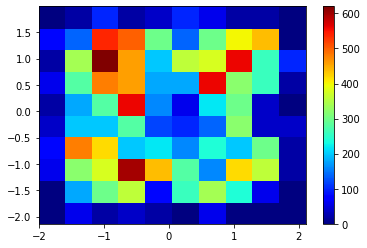

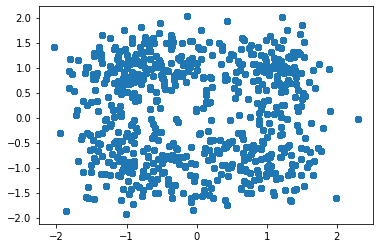

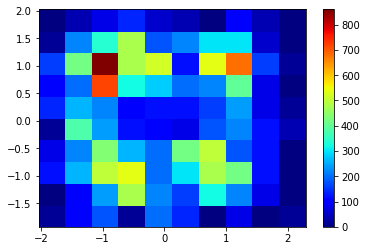

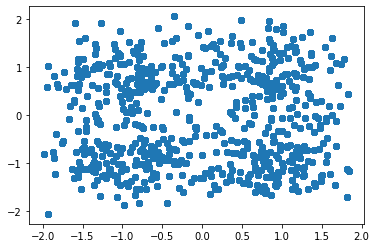

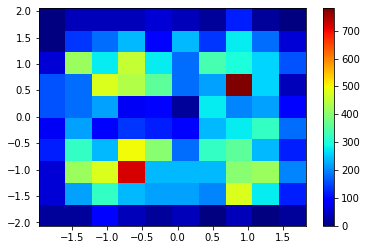

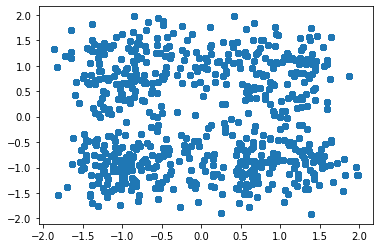

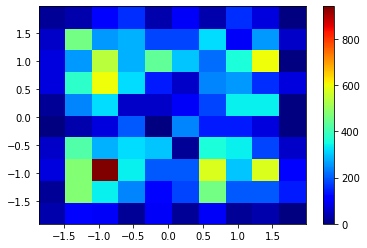

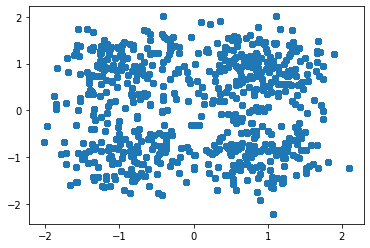

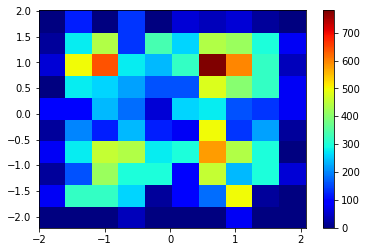

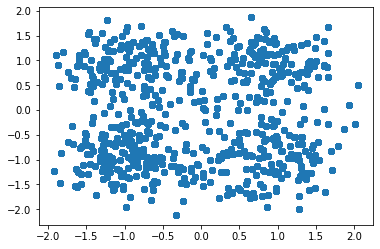

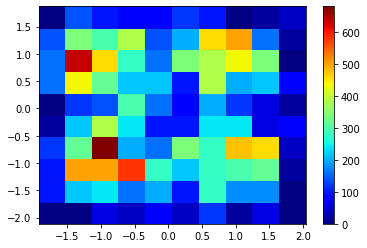

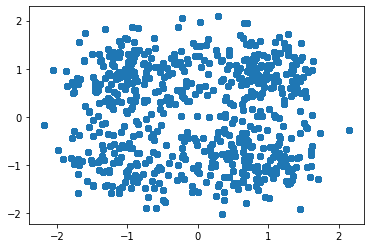

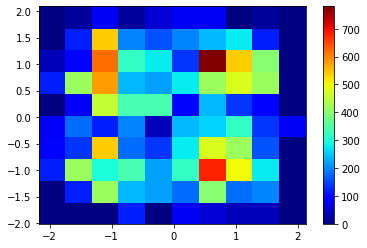

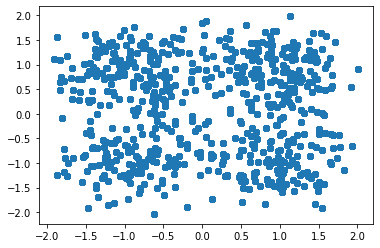

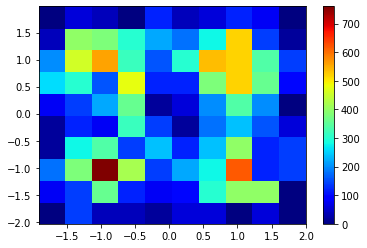

In [8]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

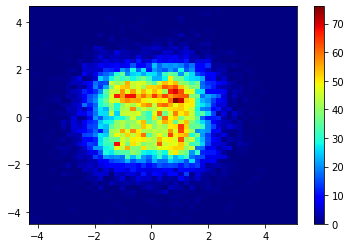

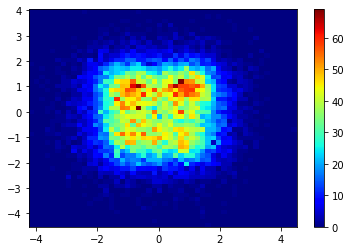

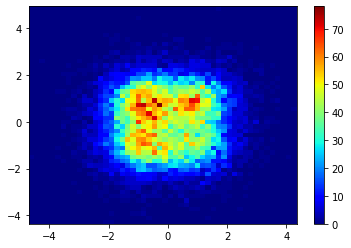

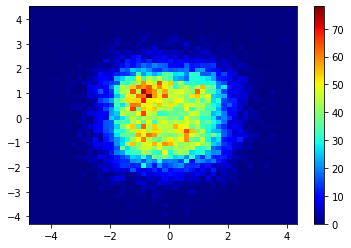

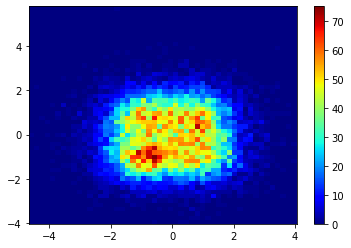

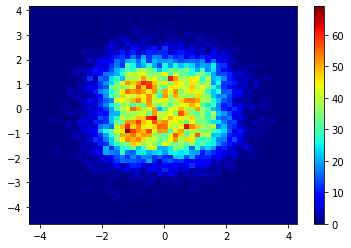

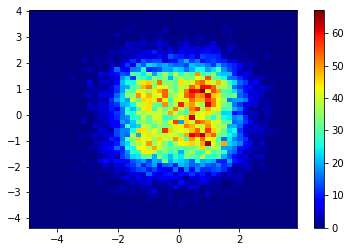

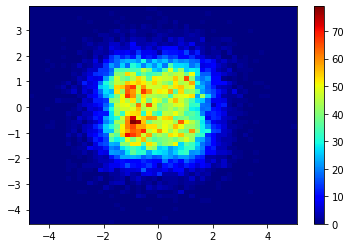

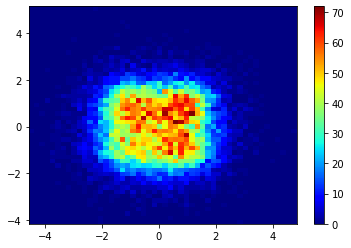

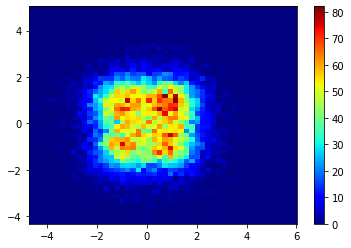

In [9]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [10]:
post_train_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
post_train_input_message_one_hot = numpy.zeros((post_train_input_message.size, 2**input_message_length))
post_train_input_message_one_hot[numpy.arange(post_train_input_message.size),post_train_input_message] = 1
print(post_train_input_message_one_hot)
print (post_train_input_message_one_hot.shape)
print (post_train_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 1024)
(1, 10000)


In [ ]:
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

#train_init = tf.global_variables_initializer ()
#train_sess = tf.Session ()

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = post_train_input_message_one_hot [i:i+1]
    encoded_message = encoder.predict(input_message_xx)
    noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,2*channel_size])
    decoded_message = decoder.predict(noised_message)
    if (numpy.argmax(post_train_input_message_one_hot[i]) != numpy.argmax(decoded_message[0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 19.19s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 38.97s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 58.43s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 77.69s
SNR: 0.000:
 -> BER: 0.33
 -> Total Time: 194.28s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 19.41s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 39.18s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 58.58s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 78.02s
SNR: 0.500:
 -> BER: 0.26
 -> Total Time: 195.19s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 19.38s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 38.27s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 57.48s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 76.90s
SNR: 1.000:
 -> BER: 0.19
 -> Total Time: 192.02s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 19.38s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 38.92s
SNR: 1.500 - Iter: 75

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(input=9,channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()